In [46]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

In [63]:
## © m4rk0V1  :\
##code for coupled neural oscillator using WC model


# Note: "subpopulations" of a node mean the excitatory and inhibitory components/populations inside a particular node.
# Each 'node' is a separate WC oscillator. (pink and blue diagram, paper2 fig 1a.)


######################################################
#Parameter values here. All chosen to keep the system(i.e. each isolated node) in oscillatory regime. 

N = 266       #Number of nodes (coupled WC oscillators).
#k = N - 1   # k is the degree of a node
w = 10     #Reperesents the connection strength between nodes.

# Homogeneous, globally connected system considered heere-
# i.e. All links have same strength = w/k .

# tau_u, tau_v = time constants.
tau_u= 8  
tau_v= 8

# r_u(r_u) =  scales feedback from the exc/inh pop's current activity u_i(v_i) to its own input. 
# i.e. it adjusts the self-regulation of the excitatory population; a higher value of r = stronger self-inhibition.
r_u= 1
r_v= 1

# c_(u,v) are the strength of interactions within & b/w the subpopulatiosn of a node.
c_uu= 16
c_vu= 15
c_uv= 12
c_vv= 3

# a = related to steepness of the sigmoid.
a_u= 1.3
a_v= 2

# theta = threshold parameter of the sigmoid.
theta_u= 4
theta_v= 3.7

# I_ext = external stimuli to the 2 subpops rsply.
I_u_ext= np.array([1.25] * N)   # All N nodes in the u subpop.
I_v_ext= np.array([0.0] * N)      # All N nodes in the v subpop.



########################################################

In [64]:
# Load the CSV file
file_path = '/Users/markov/Documents/connectome_links.csv' 
data = pd.read_csv(file_path, header=None)

# separating source and target nodes, might help later
# < it did help later, infact :) >
src_nodes = data.iloc[:, 0]
tgt_nodes = data.iloc[:, 1]

# making list of (source, target) pairs 
connectome_links = list(zip(src_nodes, tgt_nodes))

# list of all possible nodes (cuz in the connectome_links, there are some nodes absent entirely)
all_nodes = np.arange(1, N+1)  # Nodes from 1 to 266

# making the adjacency matrix
adj_matrix = np.zeros((len(all_nodes), len(all_nodes)), dtype=int)

# fill in the the adjacency matrix using the connectome_links list
for src, tgt in connectome_links:
    src_idx = src - 1  # Adjust index to be zero-based
    tgt_idx = tgt - 1 
    adj_matrix[src_idx, tgt_idx] = 1   ## this matrix is in (source, target) form. 
    #adj_matrix[tgt_idx, src_idx] = 1  ## same matrix in target, source form, if needed

# convert adjacency matrix to dataframe for better readability
adj_matrix_df = pd.DataFrame(adj_matrix, index=all_nodes, columns=all_nodes)


#print(adj_matrix_df)

#print("First row: ", adj_matrix_df.iloc[0, :])
#print(adj_matrix_df.iloc[-1, :])
#print("First col:", adj_matrix_df.iloc[:, 0])
#print(adj_matrix_df.iloc[:, -1])


#if u wanna check individual entries
print(adj_matrix_df.loc[1, 100])

#print(connectome_links[0])
#print(connectome_links[1])



1


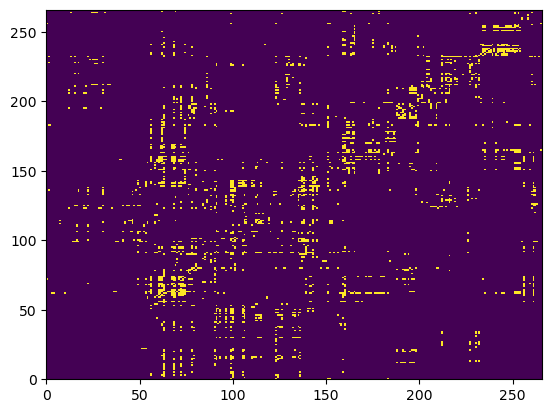

In [65]:
plt.pcolor(adj_matrix)

In [66]:
# Calculate the sum of each row (out-degree  of each node)
out_degrees = np.sum(adj_matrix, axis=1)


# Calculate the sum of each column (in-degree of each node)
## THIS IS THE SET OF INPUTS for the k values.
in_degrees = np.sum(adj_matrix, axis=0)

out_degrees_df = pd.DataFrame({
    'Node': all_nodes,
    'Out-Degree': out_degrees,
})

print(out_degrees_df)


# Calculate the total degree (in-degree + out-degree)
total_degrees = in_degrees + out_degrees


# Combine the degrees into a DataFrame for better readability
degrees_df = pd.DataFrame({
    'Node': all_nodes,
    'Out-Degree': out_degrees,
    'In-Degree': in_degrees,
    'Total Degree': total_degrees
})

print(degrees_df)

print(adj_matrix[:,0])
print(adj_matrix[0,:])


     Node  Out-Degree
0       1           5
1       2           3
2       3           4
3       4          11
4       5           4
..    ...         ...
261   262           0
262   263           1
263   264           9
264   265          10
265   266           5

[266 rows x 2 columns]
     Node  Out-Degree  In-Degree  Total Degree
0       1           5          2             7
1       2           3          4             7
2       3           4          1             5
3       4          11          1            12
4       5           4          1             5
..    ...         ...        ...           ...
261   262           0         31            31
262   263           1         11            12
263   264           9          2            11
264   265          10          1            11
265   266           5          2             7

[266 rows x 4 columns]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [67]:
# Calculating the sum of each row, this is the set of inputs for the k values.
#k_list = np.sum(adj_matrix, axis=1)

#print(k_list)




In [68]:

########################################################
# Main functions go here.


# kappa (= max values of the sigmoidal response functions for the 2 subpops)
kappa_u = 1 - 1/(1 + np.exp(a_u * theta_u))
kappa_v = 1 - 1/(1 + np.exp(a_v * theta_v))


## Sigmoidal func in the WC moel.
# reps the firing rates of the u and v subpops as a function of their nputs.

def sigmoid(z, a, theta):
    return 1/(1 + np.exp(-a*(z - theta)))

def S_u(z):
    return kappa_u - 1 + sigmoid(z, a_u, theta_u)

def S_v(z):
    return kappa_v - 1 + sigmoid(z, a_v, theta_v)

# func that returns u_in and v_in (goes inside S_u and S_v in place of z).  # mind that summation in paper. this is 3rd time debugging, bug was here all the time :,)
def inputs(u, v, k):
    u_in = np.zeros(N)
    v_in = np.zeros(N)
    
    for i in range(N):
        if k[i] == 0:
            u_in[i] = c_uu * u[i] - c_uv * v[i] + I_u_ext[i]
            v_in[i] = c_vu * u[i] - c_vv * v[i] + I_v_ext[i]
        else:
            sum_u_v = np.sum(adj_matrix[:, i] * (u - v))
            u_in[i] = c_uu * u[i] - c_uv * v[i] + (w / (N-1)) * sum_u_v + I_u_ext[i]   # replace the (N-1) with k[i] for both u and v here, for connectome data integration. 
            v_in[i] = c_vu * u[i] - c_vv * v[i] + (w / (N-1)) * sum_u_v + I_v_ext[i]   # this N-1 is for the homogenous globally connected case in pap1_2.
    
    return u_in, v_in



## Differential eqns of the WC model, returns udot and vdot.
#THIS IS THE MAIN CONTROL. wherethe y (input) goes in.
def wilson_cowan_ode(y, t):
    
    u = y[:N]                   # y is of the form = [ u1, u2,..., uN, v1, v2..., vN ]; first N obj are u's, next N obj are v's.
    v = y[N:]
    k= in_degrees[:]

    u_in, v_in = inputs(u, v, k)
    
    du_dt = (-u + (kappa_u - r_u*u) * S_u(u_in)) / tau_u
    dv_dt = (-v + (kappa_v - r_v*v) * S_v(v_in)) / tau_v
    
    return np.concatenate([du_dt, dv_dt])



#RK4 method general codes. 
# f1 = the differential equations. y,t,dt == y,x,h.
def rk4_step(f1, y, t, dt):
    k1 = dt*f1(y,t)
    k2 = dt*f1(y + 0.5*k1, t + 0.5*dt)
    k3 = dt*f1(y + 0.5*k2, t + 0.5*dt)
    k4 = dt*f1(y + k3, t + dt)
    
    return y + (k1 + 2*k2 + 2*k3 + k4) / 6




##################################################

#print(kappa_u/r_u)

In [80]:
##################################################
## Initial conditions go here.

#y0 = np.array([ 0.3, 0.1, 0.4, 0.2])    # y0= [ u1, u2,..., uN, v1, v2..., vN ] = starting pt in phase diagram

#u_init = np.array([0.3] * N)
#v_init = np.array([0.1] * N)
#y0 = np.concatenate([u_init, v_init])  #  gives the array [ u1, u2,..., uN, v1, v2..., vN ], u and v vals repeated N times.



u_init=[]
v_init=[]

for i in range(N):
    x= random.uniform(0,1)
    u_init.append(x)
    y= random.uniform(0,1)
    v_init.append(y)

y0 = np.concatenate([u_init, v_init])

#y0 = np.tile([0.3, 0.1], N)             # tile gives the array 0.3, 0.1 repeated N times. this is still 1D array btw.


# "y" in general just storing the initial values of starting points; modify as neededd


#length of time for which the sim gonna be run:
t_start = 0
t_end = 400
dt = 0.01
timeseries = np.arange(t_start, t_end, dt)

## Initializing the solution array to store the time-series results.
# stores the values of u & v, for each time step. 
# 2D array, [len(time) x 2N] matrix. Each row = diff timestep. In each row, 1st N columns = u values, 2nd N cols= v values. (like the y matrices.)
sol = np.zeros((len(timeseries), 2*N))   # 2*N because we store both u and v for each node.

# updating sol using rk4:
y = y0
for index, t in enumerate(timeseries):
    sol[index] = y
    y = rk4_step(wilson_cowan_ode, y, t, dt)  



#print(sol)


In [81]:
print(len(sol))

40000


In [82]:
######################################

## Try out whatever here 
# experiment cell



#u_exp=np.array([0.1,0.5])
#v_exp=np.array([0.0,0.0])


#inputs(u_exp, v_exp)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


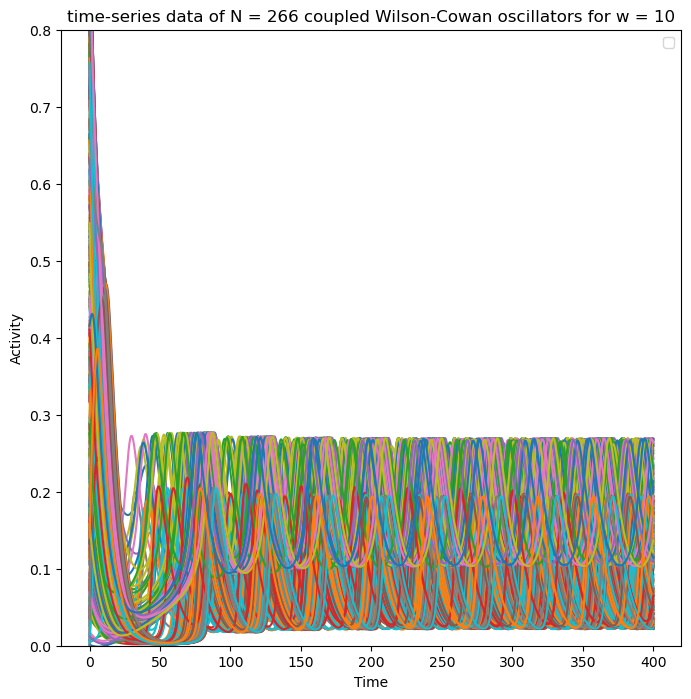

In [83]:
#########################################################

# Plotting:

# Time series plot
plt.figure(figsize=(8, 8))
for i in range(N):
    plt.plot(timeseries, sol[:, i])   #, label=f'u{i+1} '   insert this for label
    plt.plot(timeseries, sol[:, N + i])  #, label=f'v{i+1}' insert this for label

plt.ylim(0.0,0.8)
plt.xlabel('Time')
plt.ylabel('Activity')
plt.legend()
plt.title(f'time-series data of N = {N} coupled Wilson-Cowan oscillators for w = {w}')
plt.show()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


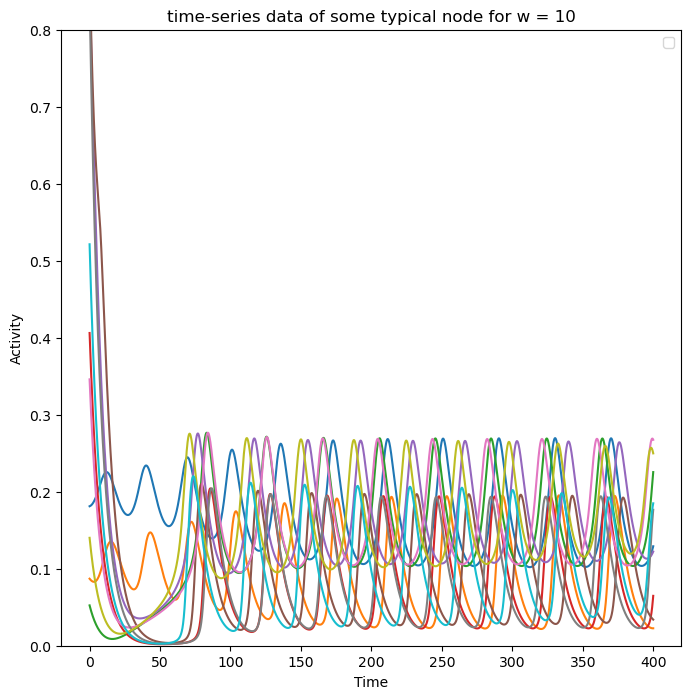

In [84]:
plt.figure(figsize=(8, 8))
for i in range(5):
    plt.plot(timeseries, sol[:, 40*i])   #, label=f'u{i+1} '   insert this for label
    plt.plot(timeseries, sol[:, N + 40*i])  #, label=f'v{i+1}' insert this for label

plt.ylim(0.0,0.8)
plt.xlabel('Time')
plt.ylabel('Activity')
plt.legend()
plt.title(f'time-series data of some typical node for w = {w}')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


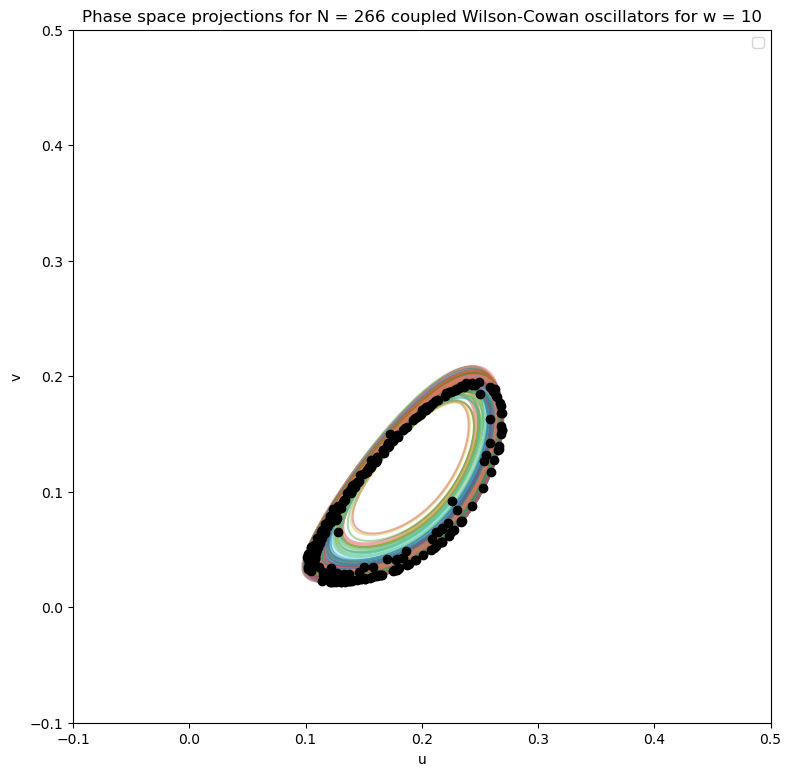

In [86]:
# Phase space plot
plt.figure(figsize=(9, 9))
for i in range(N):
    plt.plot(sol[-20000:-1, i], sol[-20000:-1, N + i], alpha= 0.4)  #, label=f'Phase space of oscillator {i+1}'
    plt.scatter(sol[-1, i], sol[-1, N + i], color='black', zorder=5)  # Ending point as a black dot. 
    #'zorder= 5' takes dot to outer layer in image, normally zorder is 2 or 3.
plt.xlim(-0.1,0.5)
plt.ylim(-0.1,0.5)
plt.xlabel('u')                    
plt.ylabel('v')
plt.legend()
plt.title(f'Phase space projections for N = {N} coupled Wilson-Cowan oscillators for w = {w}')
plt.show()


##################################################

In [ ]:
##################################################


# Func to generate trajectories for different initial starting points.
def generate_trajectory(u_start, v_start):
    y0 = np.tile([u_start, v_start], N)  # Starting point in the phase diagram

    #length of time for which the sim gonna be run:
    t_start = 0
    t_end = 150
    dt = 0.01
    timeseries = np.arange(t_start, t_end, dt)

    ## Initializing the solution array to store the time-series results.
    # stores the values of u & v, for each time step. 
    # 2D array, [len(time) x 2N] matrix. Each row = diff timestep. In each row, 1st N columns = u values, 2nd N cols= v values. (like the y matrices.)
    sol = np.zeros((len(timeseries), 2*N))   # 2*N because we store both u and v for each node.

    # Update sol for all timesteps
    y = y0
    for index, t in enumerate(timeseries):
        sol[index] = y
        y = rk4_step(wilson_cowan_ode, y, t, dt)

    return sol




# Generating trajectories for different initial starting points
trajectories = []
for u_start in np.arange(0, 1.1, 0.1):
    for v_start in np.arange(0, 1.1, 0.1):
        trajectories.append(generate_trajectory(u_start, v_start))




# Plotting phase space for all trajectories
plt.figure(figsize=(9, 9))
for tragic in trajectories:
    plt.plot(tragic[:, :N], tragic[:, N:], color='blue', alpha=0.2)
    plt.scatter(tragic[-1, :N], tragic[-1, N:], color='black', zorder=0.04)  # Black dot at the end of each trajectory
    #'zorder= 5' takes dot to outer layer in image, normally zorder is 2 or 3.
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.xlabel('u')
plt.ylabel('v')
plt.title(f'Phase space projections for coupled Wilson-Cowan oscillators')
plt.show()

In [ ]:
# Plotting phase space for all trajectories
plt.figure(figsize=(9, 9))
for tragic in trajectories:
    plt.plot(tragic[:, :N], tragic[:, N:], color='blue', alpha=0.02)
    plt.scatter(tragic[-1, :N], tragic[-1, N:], color='black', zorder=8)  # Black dot at the end of each trajectory
    #'zorder= 5' takes dot to outer layer in image, normally zorder is 2 or 3.
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.xlabel('u')
plt.ylabel('v')
plt.title(f'Phase space projections for coupled Wilson-Cowan oscillators')
plt.show()